## Exploratory Data Analysis

#### In this section I explored how the average performance changes with age based on event and gender. These results are based off the cleaned performance data from World Athletics data set for the jump events. All queries use the sql database 'track_jumps.db.

#### After running the queries and building the visualizations this notebook was reorganized by event. 

In [39]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

In [19]:
conn = sqlite3.connect("../track_jumps.db")

In [20]:
FIG_DIR = Path("../visuals/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
custom_palette = [
    "#BC94FF", 
    "#DB8EA7",
    "#F2B762",
    "#5F4782",
    "#533F73"
]

#### Data Filtering
Before creatiing visualizations data was filtered so meaningful comparisons can be made. This was to ensure any trends observed are real patterns and not noise.
- Age restricted 
- Minimum sample size applied to avoid skewed results
- Filtered by event and gender

In [264]:
base_query = """
SELECT
    e.event_name,
    e.gender,
    f.age,
    ROUND(AVG(f.mark), 2) AS avg_mark,
    COUNT(*) AS performances
FROM fact_performances f
JOIN dim_events e
    ON f.event_id = e.event_id
WHERE f.age BETWEEN 12 AND 35
GROUP BY
    e.event_name,
    e.gender,
    f.age
HAVING COUNT(*) >= 30
ORDER BY
    e.event_name,
    e.gender,
    f.age;
"""
# Verifying query works
df_age_trends = pd.read_sql(base_query, conn)
df_age_trends.head()

,event_name,gender,age,avg_mark,performances
0,high jump,F,16,1.92,57
1,high jump,F,17,1.94,87
2,high jump,F,18,1.97,82
3,high jump,F,19,1.97,135
4,high jump,F,20,1.97,200


In [303]:
# ele_query used the averages of age group with at least 100 occurances within an elevation range. The results were too small to use so I used age_elevation_query below and dropped 'Sea=level'

ele_query = """
SELECT
    e.event_name,
    e.gender,
    f.age,
    CASE
        WHEN m.elevation >= 200 THEN 'High Elevation (≥1000m)'
        WHEN m.elevation = 0 THEN 'Sea-level'
        ELSE 'Low Elevation (<1000m)'
    END AS elevation_group,
    ROUND(AVG(f.mark), 2) AS avg_mark,
    COUNT(*) AS performances
FROM fact_performances f
JOIN dim_events e
    ON f.event_id = e.event_id
JOIN dim_meets m
    ON f.meet_id = m.meet_id
WHERE f.age BETWEEN 12 AND 35
GROUP BY
    e.event_name,
    e.gender,
    f.age,
    elevation_group
HAVING COUNT(*) >= 100
ORDER BY
    e.gender,
    elevation_group,
    f.age;
"""

df_elevation = pd.read_sql(ele_query, conn)
df_elevation.head(20)

,event_name,gender,age,elevation_group,avg_mark,performances
0,triple jump,F,22,High Elevation (≥1000m),14.29,139
1,long jump,F,23,High Elevation (≥1000m),6.91,112
2,triple jump,F,23,High Elevation (≥1000m),14.34,174
3,high jump,F,24,High Elevation (≥1000m),1.98,122
4,long jump,F,24,High Elevation (≥1000m),6.89,132
5,triple jump,F,24,High Elevation (≥1000m),14.34,169
6,high jump,F,25,High Elevation (≥1000m),1.98,134
7,long jump,F,25,High Elevation (≥1000m),6.90,129
8,triple jump,F,25,High Elevation (≥1000m),14.36,233
9,high jump,F,26,High Elevation (≥1000m),1.98,107


In [ ]:
# age_elevation_query averages the performances by age, elevation, and event with 10 occurances. 

age_elevation_query = """
SELECT
    e.event_name,
    e.gender,
    f.age,
    CASE
        WHEN m.elevation >= 1000 THEN 'High'
        ELSE 'Low'
    END AS elevation_group,
    ROUND(AVG(f.mark), 2) AS avg_mark,
    COUNT(*) AS performances
FROM fact_performances f
JOIN dim_events e
    ON f.event_id = e.event_id
JOIN dim_meets m
    ON f.meet_id = m.meet_id
WHERE f.age BETWEEN 12 AND 35
GROUP BY
    e.event_name,
    e.gender,
    f.age,
    CASE
        WHEN m.elevation >= 1000 THEN 'High'
        ELSE 'Low'
    END
HAVING COUNT(*) >= 10
ORDER BY
    e.event_name,
    e.gender,
    f.age;
"""

df_age_elev = pd.read_sql(age_elevation_query, conn)
df_age_elev.head()

,event_name,gender,age,elevation_group,avg_mark,performances
0,high jump,F,16,Low,1.91,50
1,high jump,F,17,Low,1.93,80
2,high jump,F,18,High,1.98,10
3,high jump,F,18,Low,1.97,72
4,high jump,F,19,High,1.96,10


In [ ]:
# age_perf_query looks at the average preformance from only athletes who competed in all three age categories.

age_perf_query = """
SELECT
    e.event_name,
    e.gender,
    f.age,
    ROUND(AVG(f.mark), 2) AS avg_mark,
    COUNT(*) AS performances
FROM fact_performances f
JOIN dim_events e
    ON f.event_id = e.event_id
WHERE f.age BETWEEN 12 AND 35
AND f.athlete_id IN (
    SELECT athlete_id
    FROM fact_performances
    GROUP BY athlete_id
    HAVING COUNT(DISTINCT age_group) = 3
)
GROUP BY
    e.event_name,
    e.gender,
    f.age
HAVING COUNT(*) >= 30
ORDER BY
    e.event_name,
    e.gender,
    f.age;
"""

df_age_trends = pd.read_sql(age_perf_query, conn)
df_age_trends.head()

,event_name,gender,age,avg_mark,performances
0,high jump,F,16,1.93,31
1,high jump,F,17,1.94,69
2,high jump,F,18,1.97,66
3,high jump,F,19,1.98,68
4,high jump,F,20,1.97,68


## High Jump

In [64]:
hj_df = df_age_trends[df_age_trends["event_name"] == "high jump"]
hj_df.head()

,event_name,gender,age,avg_mark,performances
0,high jump,F,16,1.92,57
1,high jump,F,17,1.94,87
2,high jump,F,18,1.97,82
3,high jump,F,19,1.97,135
4,high jump,F,20,1.97,200


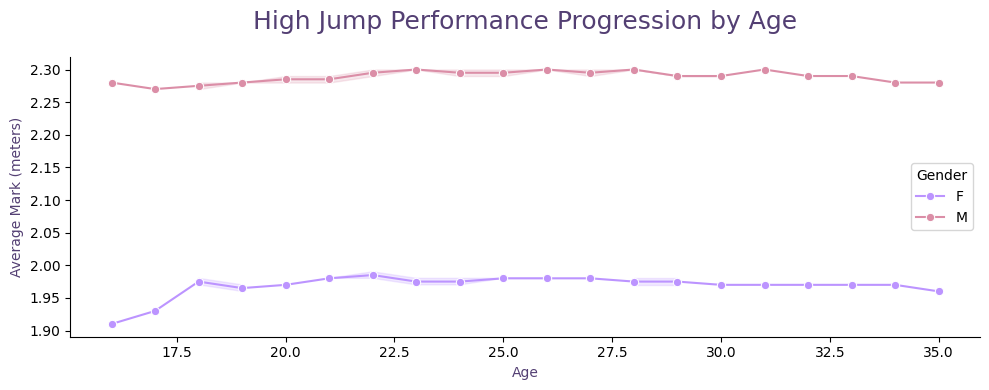

In [261]:
plt.figure(figsize=(10,4))

sns.lineplot(
    data=hj_df,
    x="age",
    y="avg_mark",
    hue="gender",
    marker="o",
    palette=custom_palette[:2]
)

plt.title("High Jump Performance Progression by Age", color="#533F73", fontsize=18, pad=20)
plt.xlabel("Age", color="#533F73")
plt.ylabel("Average Mark (meters)", color="#533F73")
plt.legend(title="Gender")
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR /"high_jump_age_progression.png", dpi=300, bbox_inches="tight")
plt.show()


#### Looking at the Progression Progress of High Jumpers, we can see men tend to peak and decline sooner than women. However, the average performance of women tends to remain steady at 30 years on, where men's preformance after 30 is more varied.

In [248]:
hj_df = df_age_elev[df_age_elev["event_name"] == "high jump"]

In [249]:
hj_m_all = hj_df[(hj_df["gender"] == "M")]
hj_m_low = hj_df[(hj_df["gender"] == "M") & (hj_df["elevation_group"] == "Low")]
hj_m_high = hj_df[(hj_df["gender"] == "M") & (hj_df["elevation_group"] == "High")]

hj_w_all = hj_df[(hj_df["gender"] == "F")]
hj_w_low = hj_df[(hj_df["gender"] == "F") & (hj_df["elevation_group"] == "Low")]
hj_w_high = hj_df[(hj_df["gender"] == "F") & (hj_df["elevation_group"] == "High")]

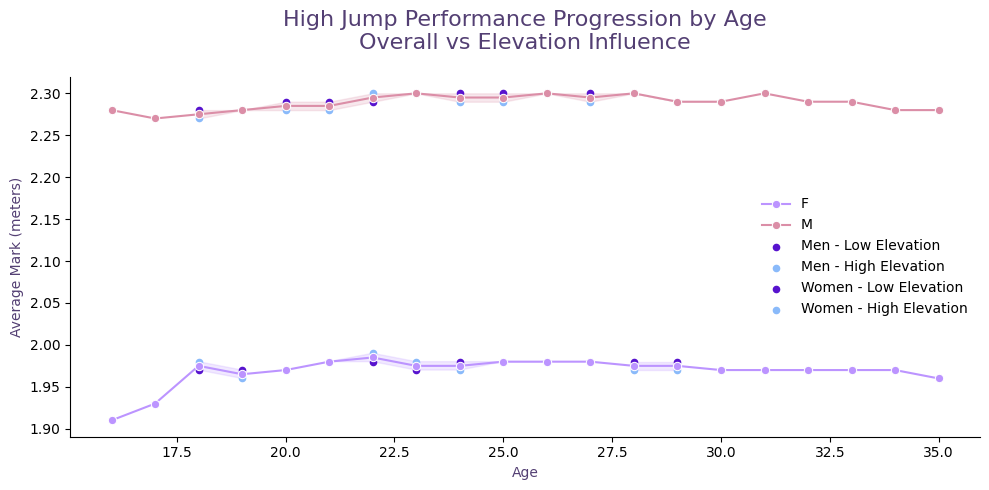

In [293]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=hj_df,
    x="age",
    y="avg_mark",
    hue="gender",
    marker="o",
    palette=custom_palette[:2]
)

# Men
plt.scatter(
    hj_m_low["age"], hj_m_low["avg_mark"],
    label="Men - Low Elevation",
    color="#5713CE", 
    s=20
)

plt.scatter(
    hj_m_high["age"], hj_m_high["avg_mark"],
    label="Men - High Elevation",
    color="#8ABAFA",
    s=20
)

# Women

plt.scatter(
    hj_w_low["age"], hj_w_low["avg_mark"],
    label="Women - Low Elevation",
    color="#5713CE", 
    s=20
)

plt.scatter(
    hj_w_high["age"], hj_w_high["avg_mark"],
    label="Women - High Elevation",
    color="#8ABAFA",
    s=20
)

plt.title(
    "High Jump Performance Progression by Age\nOverall vs Elevation Influence",
    fontsize=16,
    pad=20,
    color="#533F73"
)
plt.xlabel("Age", color="#533F73")
plt.ylabel("Average Mark (meters)", color="#533F73")

plt.xlabel("Age")
plt.ylabel("Average Mark (meters)")
plt.legend(frameon=False)
plt.grid(False)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR /"high_jump_overall_with_elevation.png", dpi=300, bbox_inches="tight")
plt.show()

Elevation was added to look at how environmental factors (elevation) effect jumpers. Women seem to have better average performances at low evelation where the data is available. 

In [96]:
hj_df = df_age_trends[df_age_trends["event_name"] == "high jump"]
print(hj_df.shape)
hj_df.head()

(24, 5)


,event_name,gender,age,avg_mark,performances
0,high jump,F,16,1.93,31
1,high jump,F,17,1.94,69
2,high jump,F,18,1.97,66
3,high jump,F,19,1.98,68
4,high jump,F,20,1.97,68


In [76]:
hj_m = hj_df[hj_df["gender"] == "M"]
hj_w = hj_df[hj_df["gender"] == "F"]

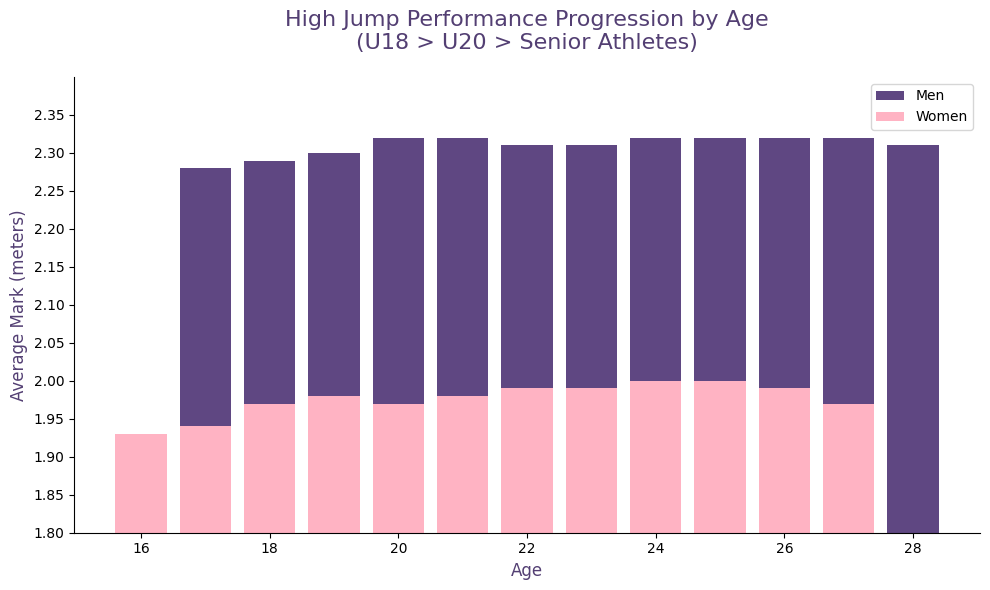

In [272]:
plt.figure(figsize=(10, 6))

plt.bar(
    hj_m["age"],
    hj_m["avg_mark"],
    label="Men",
    color="#5F4782",
    linewidth=2
)

plt.bar(
    hj_w["age"],
    hj_w["avg_mark"],
    label="Women",
    color="#FFB3C3",
    linewidth=2    
)

plt.title("High Jump Performance Progression by Age\n(U18 > U20 > Senior Athletes)", color="#533F73", fontsize=16, pad=20)
plt.xlabel("Age", color="#533F73",fontsize=12)
plt.ylabel("Average Mark (meters)", color="#533F73", fontsize=12)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(1.8, 2.4)
plt.yticks(np.arange(1.8, 2.4, 0.05))
ax = plt.gca()

ax = plt.gca()

plt.tight_layout()
plt.savefig(FIG_DIR /"high_jump_age_perfomance_progression.png", dpi=300, bbox_inches="tight")
plt.show()


Both men and women show the greatest improvement early in their careers (teen years). Men stabalize in their 20s while women have a slow increase throughout their 20s until the decline around 27.

## Pairplot

The pairplot was added to look at the overall relationship between age and performance. Due to time constraints high jump was the only event plotted.

In [326]:
# used for the sns.pairplot (high jump only)

pair_df = pair_df.rename(columns={
    "age": "Age (years)",
    "avg_mark": "Average Performance",
    "performances": "Number of Performances"
})

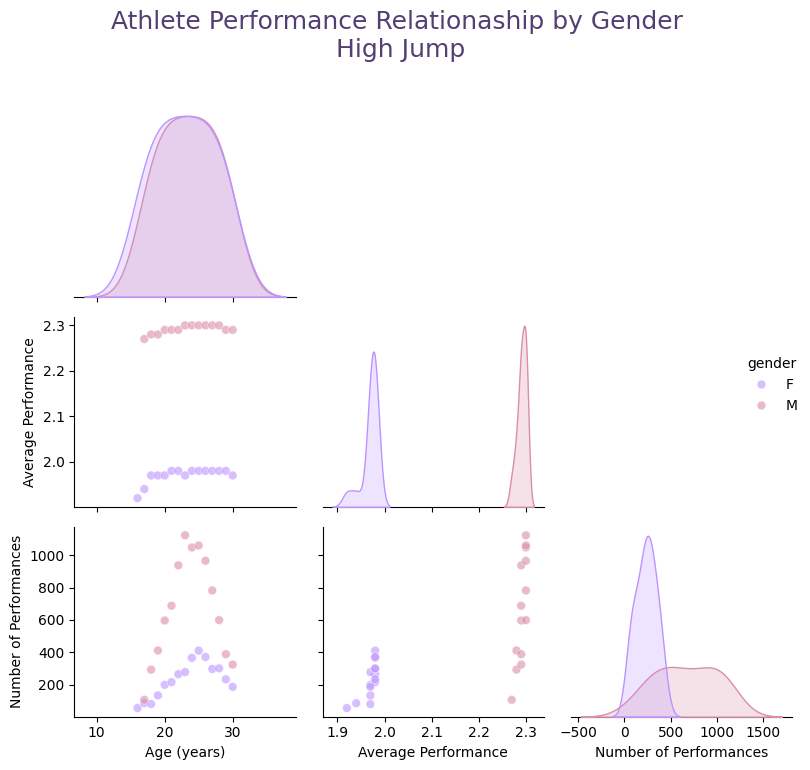

In [332]:
hj = sns.pairplot(
    pair_df,
    vars=[
        "Age (years)", 
        "Average Performance", 
        "Number of Performances"
    ],
    hue="gender",
    palette=custom_palette[:2],
    corner=True,
    plot_kws={"alpha": 0.6, "s": 40}
)

hj.figure.suptitle(
    "Athlete Performance Relationaship by Gender \nHigh Jump",
    fontsize=18,
    color="#533F73",
    y=1.02
)

plt.tight_layout()
plt.savefig(FIG_DIR /"high_jump_athlete_perfomance_relationship_gender.png", dpi=300, bbox_inches="tight")
plt.show()

## Long jump


In [265]:
lj_df = df_age_trends[df_age_trends["event_name"] == "long jump"]
lj_df.head()

,event_name,gender,age,avg_mark,performances
37,long jump,F,17,6.72,37
38,long jump,F,18,6.83,70
39,long jump,F,19,6.86,107
40,long jump,F,20,6.88,133
41,long jump,F,21,6.89,240


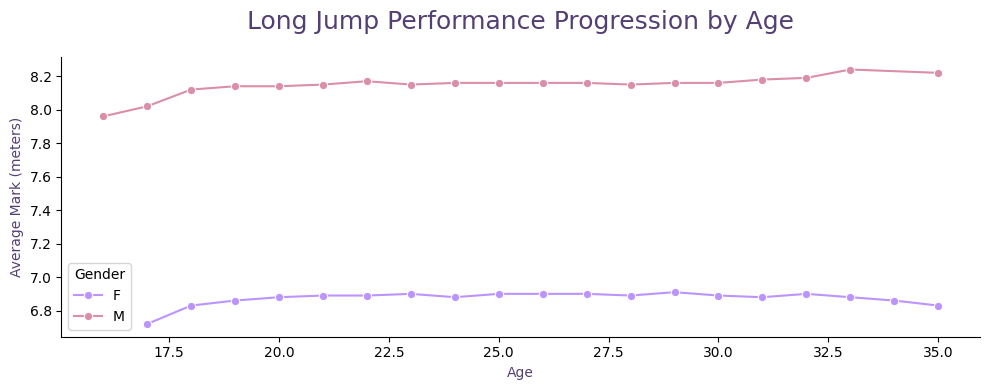

In [268]:
plt.figure(figsize=(10,4))

sns.lineplot(
    data=lj_df,
    x="age",
    y="avg_mark",
    hue="gender",
    marker="o",
    palette=custom_palette[:2]
)

plt.title("Long Jump Performance Progression by Age", color="#533F73", fontsize=18, pad=20)
plt.xlabel("Age", color="#533F73")
plt.ylabel("Average Mark (meters)", color="#533F73")
plt.legend(title="Gender")
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR /"long_jump_age_progression.png", dpi=300, bbox_inches="tight")
plt.show()

#### With long jump men tend to constantly imporove as they age, where women see peak performances throughout their 20's.

In [284]:
lj_df = df_age_elev[df_age_elev["event_name"] == "long jump"]

In [285]:
lj_m_all = lj_df[(lj_df["gender"] == "M")]
lj_m_low = lj_df[(lj_df["gender"] == "M") & (lj_df["elevation_group"] == "Low")]
lj_m_high = lj_df[(lj_df["gender"] == "M") & (lj_df["elevation_group"] == "High")]

lj_w_all = lj_df[(lj_df["gender"] == "F")]
lj_w_low = lj_df[(lj_df["gender"] == "F") & (lj_df["elevation_group"] == "Low")]
lj_w_high = lj_df[(lj_df["gender"] == "F") & (lj_df["elevation_group"] == "High")]

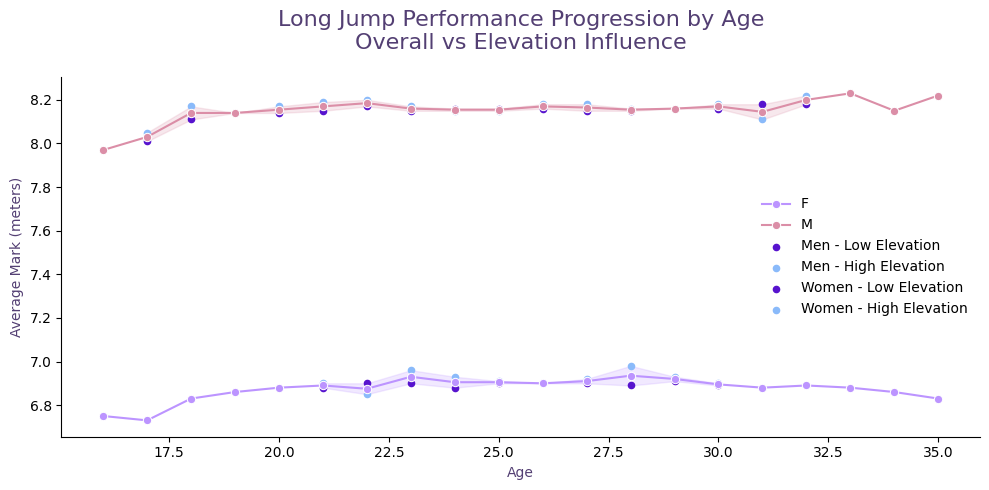

In [294]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=lj_df,
    x="age",
    y="avg_mark",
    hue="gender",
    marker="o",
    palette=custom_palette[:2]
)

# Men
plt.scatter(
    lj_m_low["age"], lj_m_low["avg_mark"],
    label="Men - Low Elevation",
    color="#5713CE", 
    s=20
)

plt.scatter(
    lj_m_high["age"], lj_m_high["avg_mark"],
    label="Men - High Elevation",
    color="#8ABAFA",
    s=20
)

# Women

plt.scatter(
    lj_w_low["age"], lj_w_low["avg_mark"],
    label="Women - Low Elevation",
    color="#5713CE", 
    s=20
)

plt.scatter(
    lj_w_high["age"], lj_w_high["avg_mark"],
    label="Women - High Elevation",
    color="#8ABAFA",
    s=20
)

plt.title(
    "Long Jump Performance Progression by Age\nOverall vs Elevation Influence",
    fontsize=16,
    pad=20,
    color="#533F73"
)
plt.xlabel("Age", color="#533F73")
plt.ylabel("Average Mark (meters)", color="#533F73")

plt.xlabel("Age")
plt.ylabel("Average Mark (meters)")
plt.legend(frameon=False)
plt.grid(False)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR /"long_jump_overall_with_elevation.png", dpi=300, bbox_inches="tight")
plt.show()

Both men and women show higher than average performances at high elevation.

In [274]:
lj_df = df_age_trends[df_age_trends["event_name"] == "long jump"]
print(lj_df.shape)
lj_df.head()

(38, 5)


,event_name,gender,age,avg_mark,performances
37,long jump,F,17,6.72,37
38,long jump,F,18,6.83,70
39,long jump,F,19,6.86,107
40,long jump,F,20,6.88,133
41,long jump,F,21,6.89,240


In [275]:
lj_m = lj_df[lj_df["gender"] == "M"]
lj_w = lj_df[lj_df["gender"] == "F"]

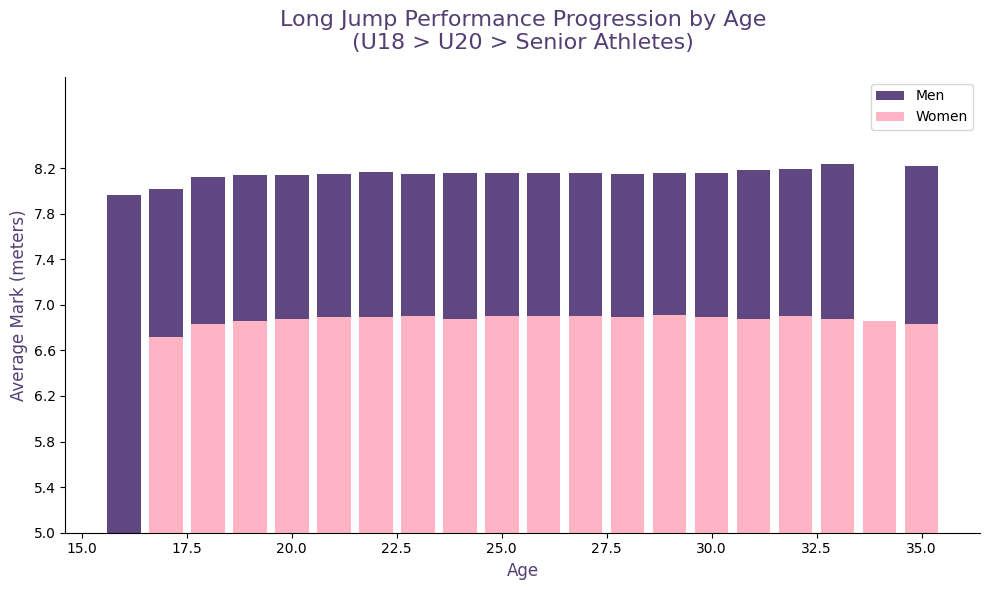

In [276]:
plt.figure(figsize=(10, 6))

plt.bar(
    lj_m["age"],
    lj_m["avg_mark"],
    label="Men",
    color="#5F4782",
    linewidth=2
)

plt.bar(
    lj_w["age"],
    lj_w["avg_mark"],
    label="Women",
    color="#FFB3C3",
    linewidth=2    
)

plt.title("Long Jump Performance Progression by Age\n(U18 > U20 > Senior Athletes)", color="#533F73", fontsize=16, pad=20)
plt.xlabel("Age", color="#533F73",fontsize=12)
plt.ylabel("Average Mark (meters)", color="#533F73", fontsize=12)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(5, 9)
plt.yticks(np.arange(5, 8.5, 0.4))
ax = plt.gca()

plt.tight_layout()
plt.savefig(FIG_DIR /"long_jump_age_perfomance_progression.png", dpi=300, bbox_inches="tight")
plt.show()

Men's long jump has the youngest athlete to compete in all age categories. Both genders show improvement in their late teens and minimal improvements throughout their 20s.

## Triple Jump
#### Men's triple jump has the least amount of progression as athletes age. Women tend to peak in their mid 20's (20-27).

In [267]:
tj_df = df_age_trends[df_age_trends["event_name"] == "triple jump"]
tj_df.head()

,event_name,gender,age,avg_mark,performances
75,triple jump,F,17,14.16,36
76,triple jump,F,18,14.19,129
77,triple jump,F,19,14.17,186
78,triple jump,F,20,14.25,288
79,triple jump,F,21,14.27,343


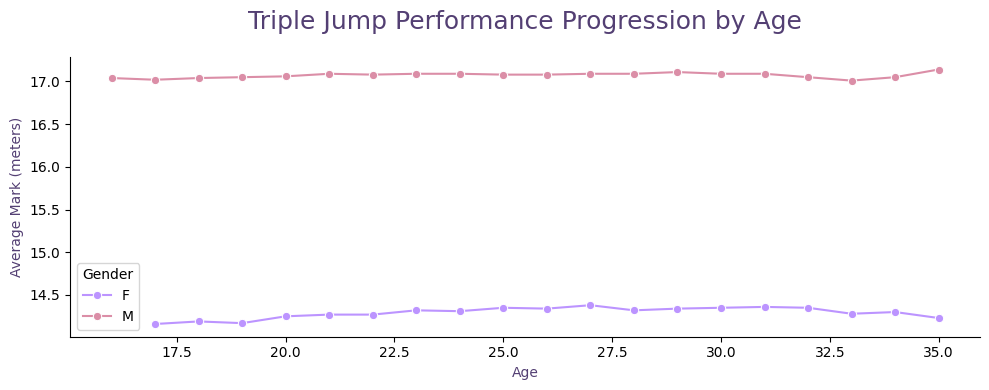

In [269]:
plt.figure(figsize=(10,4))

sns.lineplot(
    data=tj_df,
    x="age",
    y="avg_mark",
    hue="gender",
    marker="o",
    palette=custom_palette[:2]
)

plt.title("Triple Jump Performance Progression by Age", color="#533F73", fontsize=18, pad=20)
plt.xlabel("Age", color="#533F73")
plt.ylabel("Average Mark (meters)", color="#533F73")
plt.legend(title="Gender")
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR /"triple_jump_age_progression.png", dpi=300, bbox_inches="tight")
plt.show()


Men's triple jump shows the least amount of progression, where women's performance peak occurs in their late 20s between 26-27.

In [289]:
tj_df = df_age_elev[df_age_elev["event_name"] == "triple jump"]

In [291]:
tj_m_all = tj_df[(tj_df["gender"] == "M")]
tj_m_low = tj_df[(tj_df["gender"] == "M") & (tj_df["elevation_group"] == "Low")]
tj_m_high = tj_df[(tj_df["gender"] == "M") & (tj_df["elevation_group"] == "High")]

tj_w_all = tj_df[(tj_df["gender"] == "F")]
tj_w_low = tj_df[(tj_df["gender"] == "F") & (tj_df["elevation_group"] == "Low")]
tj_w_high = tj_df[(tj_df["gender"] == "F") & (tj_df["elevation_group"] == "High")]

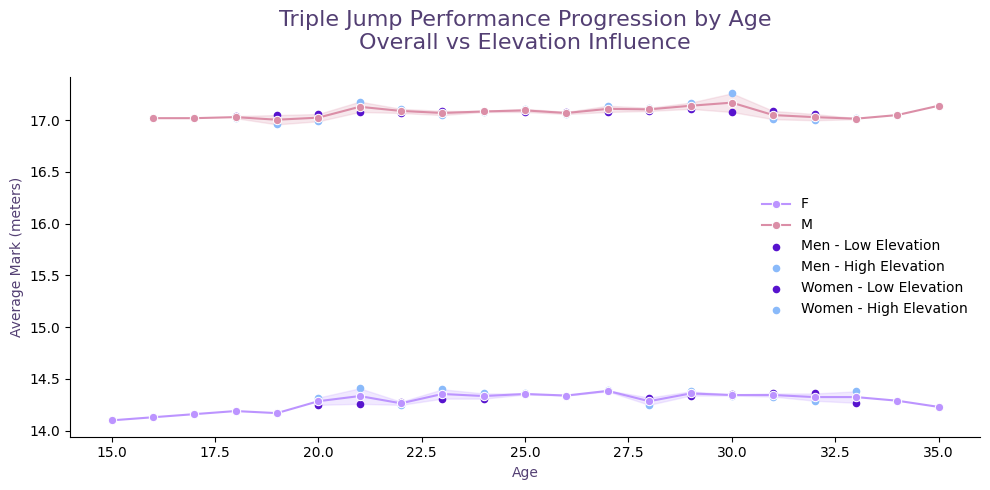

In [295]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=tj_df,
    x="age",
    y="avg_mark",
    hue="gender",
    marker="o",
    palette=custom_palette[:2]
)

# Men
plt.scatter(
    tj_m_low["age"], tj_m_low["avg_mark"],
    label="Men - Low Elevation",
    color="#5713CE", 
    s=20
)

plt.scatter(
    tj_m_high["age"], tj_m_high["avg_mark"],
    label="Men - High Elevation",
    color="#8ABAFA",
    s=20
)

# Women

plt.scatter(
    tj_w_low["age"], tj_w_low["avg_mark"],
    label="Women - Low Elevation",
    color="#5713CE", 
    s=20
)

plt.scatter(
    tj_w_high["age"], tj_w_high["avg_mark"],
    label="Women - High Elevation",
    color="#8ABAFA",
    s=20
)

plt.title(
    "Triple Jump Performance Progression by Age\nOverall vs Elevation Influence",
    fontsize=16,
    pad=20,
    color="#533F73"
)
plt.xlabel("Age", color="#533F73")
plt.ylabel("Average Mark (meters)", color="#533F73")

plt.xlabel("Age")
plt.ylabel("Average Mark (meters)")
plt.legend(frameon=False)
plt.grid(False)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.savefig(FIG_DIR /"triple_jump_overall_with_elevation.png", dpi=300, bbox_inches="tight")
plt.show()

Like long jump, triple jumpers show better average performances at higher elevation. I would like to explore this further to see if the location of the venue (northern or southern hemisphere), time of year, or weather conditions (especially barometric pressure) effect the performance at elevation.

In [277]:
tj_df = df_age_trends[df_age_trends["event_name"] == "triple jump"]
print(tj_df.shape)
tj_df.tail()

(39, 5)


,event_name,gender,age,avg_mark,performances
109,triple jump,M,31,17.09,254
110,triple jump,M,32,17.05,183
111,triple jump,M,33,17.01,127
112,triple jump,M,34,17.05,82
113,triple jump,M,35,17.14,52


In [278]:
tj_m = tj_df[tj_df["gender"] == "M"]
tj_w = tj_df[tj_df["gender"] == "F"]

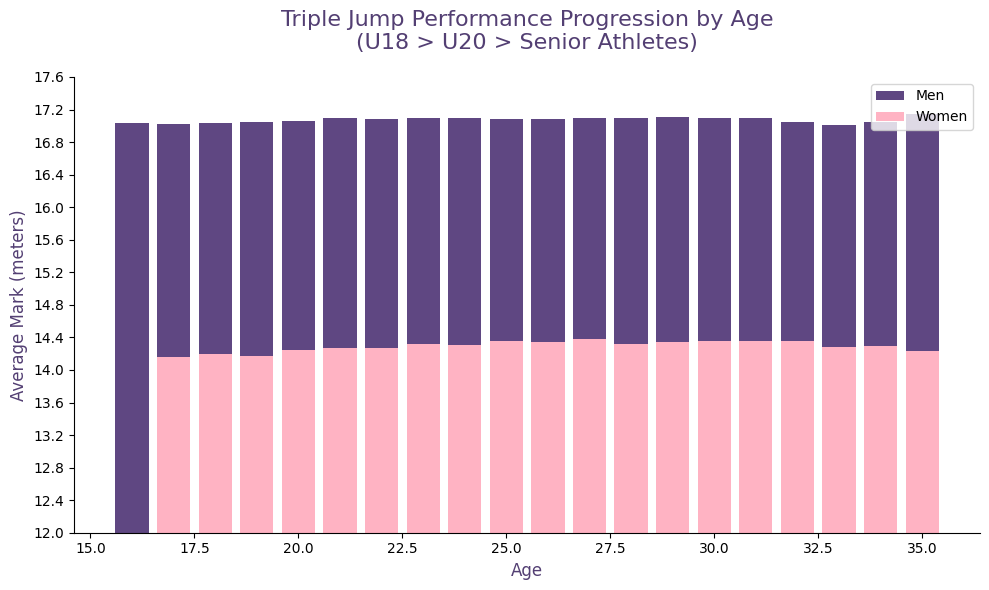

In [282]:
plt.figure(figsize=(10, 6))

plt.bar(
    tj_m["age"],
    tj_m["avg_mark"],
    label="Men",
    color="#5F4782",
    linewidth=2
)

plt.bar(
    tj_w["age"],
    tj_w["avg_mark"],
    label="Women",
    color="#FFB3C3",
    linewidth=2    
)

plt.title("Triple Jump Performance Progression by Age\n(U18 > U20 > Senior Athletes)", color="#533F73", fontsize=16, pad=20)
plt.xlabel("Age", color="#533F73",fontsize=12)
plt.ylabel("Average Mark (meters)", color="#533F73", fontsize=12)
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(12, 16)
plt.yticks(np.arange(12, 18, 0.4))
ax = plt.gca()

plt.tight_layout()
plt.savefig(FIG_DIR /"triple_jump_age_perfomance_progression.png", dpi=300, bbox_inches="tight")
plt.show()

Of the althetes who have competed in all age groups men appear to peak in their early 20s with little deviation until their early 30s. This would allow us to conclude a male triple jumper could maintain their top competitive performance for 10 years. 